In [28]:
import praw
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arunsubbiah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
#Authenticate with Reddit API

reddit = praw.Reddit(
    client_id="TNeAl59PJxaaVeX6tQcjFw",        
    client_secret="0RKBiXBELRvFg5HrhQmu3DgEQbpj8A",  
    user_agent="script:441_project:v1.0 (by u/DearAnywhere5350)",
    check_for_async=False
)

In [ ]:
from datetime import datetime

subreddits = ["Politics", "PoliticalDiscussion", "Ask_Politics"]
data = []

# Timestamp for Jan 1, 2025
start_timestamp = datetime(2025, 1, 1).timestamp()

for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    
    # Combine different types of post listings
    for listing_type, time_filter in [
        ("hot", None),
        ("top", "year"),
        ("controversial", "year")
    ]:
        print(f"Fetching {listing_type} posts from r/{sub} (2025 only)...")
        
        # Dynamically call the appropriate method
        if time_filter and listing_type in ["top", "controversial"]:
            submissions = getattr(subreddit, listing_type)(time_filter=time_filter, limit=60)
        else:
            submissions = getattr(subreddit, listing_type)(limit=60)
        
        for submission in submissions:
            # Filter only posts from 2025
            if submission.created_utc < start_timestamp:
                continue
            
            submission.comments.replace_more(limit=0)
            post_date = datetime.utcfromtimestamp(submission.created_utc)
            
            # Estimate downvotes
            upvotes = int(submission.score * submission.upvote_ratio)
            
            for comment in submission.comments.list()[:8]:  # limit per post
                comment_date = datetime.utcfromtimestamp(comment.created_utc)
                
                data.append({
                    "subreddit": sub,
                    "post_type": listing_type,
                    "post_title": submission.title,
                    "post_score": submission.score,
                    "upvotes": upvotes,
                    "comment": comment.body,
                    "comment_score": comment.score,
                    "post_date": post_date,
                    "comment_date": comment_date
                })

print(f"Total comments collected: {len(data)}")


Fetching hot posts from r/Politics (2025 only)...


/var/folders/xk/jpzsqp5n79949zd1dbrv80n80000gn/T/ipykernel_92758/2830398171.py:32: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_date = datetime.utcfromtimestamp(submission.created_utc)
/var/folders/xk/jpzsqp5n79949zd1dbrv80n80000gn/T/ipykernel_92758/2830398171.py:39: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  comment_date = datetime.utcfromtimestamp(comment.created_utc)


Fetching top posts from r/Politics (2025 only)...
Fetching controversial posts from r/Politics (2025 only)...
Fetching hot posts from r/PoliticalDiscussion (2025 only)...
Fetching top posts from r/PoliticalDiscussion (2025 only)...
Fetching controversial posts from r/PoliticalDiscussion (2025 only)...
Fetching hot posts from r/Ask_Politics (2025 only)...
Fetching top posts from r/Ask_Politics (2025 only)...
Fetching controversial posts from r/Ask_Politics (2025 only)...
Total comments collected: 2327


In [45]:
df = pd.DataFrame(data)
df

,subreddit,post_type,post_title,post_score,upvotes,downvotes,comment,comment_score,post_date,comment_date
0,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,Woah that is huge! Thats going to be a big 50x...,1,2025-10-08 14:31:02,2025-10-08 14:38:06
1,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,(1) How does that work with the internal affai...,1,2025-10-08 14:31:02,2025-10-08 15:19:00
2,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,"Random policy question, how do you feel about ...",1,2025-10-08 14:31:02,2025-10-08 14:41:49
3,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,"Wow... I'm going through the content, but look...",1,2025-10-08 14:31:02,2025-10-08 14:59:28
4,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,Good question was asked -- and then deleted --...,1,2025-10-08 14:31:02,2025-10-08 15:50:03
...,...,...,...,...,...,...,...,...,...,...
3052,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,"It’s exactly the opposite. Back in 2017, his a...",5,2024-11-27 06:45:09,2024-11-27 18:09:13
3053,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,Yeah--and I think the key thing to understand ...,3,2024-11-27 06:45:09,2024-11-27 23:00:52
3054,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,"Your last link is bad, and is dead",1,2024-11-27 06:45:09,2024-12-04 02:18:56
3055,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,And it looks like MIT in particular has expand...,1,2024-11-27 06:45:09,2024-12-06 16:28:50


In [46]:
#cleaning data

df.drop(df[df['comment'] == '[deleted]'].index, inplace=True)
df.drop(df[df['comment'] == '[removed]'].index, inplace=True)

df.drop_duplicates(subset=['comment'], inplace=True)

english_stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in english_stopwords]
    return ' '.join(filtered_words)

def remove_punctuation(text):
    text = text.lower()
    return ''.join(char for char in text if char.isalnum() or char.isspace())

def remove_short_comments(text, min_length=3):
    words = text.split()
    if len(words) < min_length:
        return ''
    return text

df['comment'] = df['comment'].apply(remove_stopwords)
df['comment'] = df['comment'].apply(remove_punctuation)
df['comment'] = df['comment'].apply(lambda x: remove_short_comments(x, min_length=4))
df = df[df['comment'] != '']

df

,subreddit,post_type,post_title,post_score,upvotes,downvotes,comment,comment_score,post_date,comment_date
0,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,woah huge thats going big 50x battle wish best...,1,2025-10-08 14:31:02,2025-10-08 14:38:06
1,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,1 work internal affairs doctrine lets say owne...,1,2025-10-08 14:31:02,2025-10-08 15:19:00
2,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,random policy question feel secure act 20 caus...,1,2025-10-08 14:31:02,2025-10-08 14:41:49
3,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,wow going content looks good far well done con...,1,2025-10-08 14:31:02,2025-10-08 14:59:28
4,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,good question asked deleted unions typed ful...,1,2025-10-08 14:31:02,2025-10-08 15:50:03
...,...,...,...,...,...,...,...,...,...,...
3052,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,its exactly opposite back 2017 administration ...,5,2024-11-27 06:45:09,2024-11-27 18:09:13
3053,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,yeahand think key thing understand universitie...,3,2024-11-27 06:45:09,2024-11-27 23:00:52
3054,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,last link bad dead,1,2024-11-27 06:45:09,2024-12-04 02:18:56
3055,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,looks like mit particular expanded definition ...,1,2024-11-27 06:45:09,2024-12-06 16:28:50


In [47]:
df

,subreddit,post_type,post_title,post_score,upvotes,downvotes,comment,comment_score,post_date,comment_date
0,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,woah huge thats going big 50x battle wish best...,1,2025-10-08 14:31:02,2025-10-08 14:38:06
1,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,1 work internal affairs doctrine lets say owne...,1,2025-10-08 14:31:02,2025-10-08 15:19:00
2,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,random policy question feel secure act 20 caus...,1,2025-10-08 14:31:02,2025-10-08 14:41:49
3,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,wow going content looks good far well done con...,1,2025-10-08 14:31:02,2025-10-08 14:59:28
4,Politics,hot,"I’m Tom Moore, senior fellow for democracy pol...",250,237,13,good question asked deleted unions typed ful...,1,2025-10-08 14:31:02,2025-10-08 15:50:03
...,...,...,...,...,...,...,...,...,...,...
3052,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,its exactly opposite back 2017 administration ...,5,2024-11-27 06:45:09,2024-11-27 18:09:13
3053,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,yeahand think key thing understand universitie...,3,2024-11-27 06:45:09,2024-11-27 23:00:52
3054,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,last link bad dead,1,2024-11-27 06:45:09,2024-12-04 02:18:56
3055,Ask_Politics,hot,Did Trump really cause free Tuition wave in un...,0,0,0,looks like mit particular expanded definition ...,1,2024-11-27 06:45:09,2024-12-06 16:28:50


In [48]:
tokens = " ".join(df['comment']).split()
word_counts = Counter(tokens)
common_words = word_counts.most_common(20)



In [49]:
#TF-IDF Vectorization 

corpus = df['comment'].tolist()
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,   # limit to top 5000 words to reduce dimensionality
    ngram_range=(1, 2),  # include unigrams and bigrams
)

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

print("TF-IDF matrix shape:", tfidf_matrix.shape)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[2000:2010])

TF-IDF matrix shape: (1803, 5000)
['hero' 'hes' 'hes going' 'hes lying' 'hes one' 'hey' 'hhs' 'hhs instead'
 'hidden' 'hide']


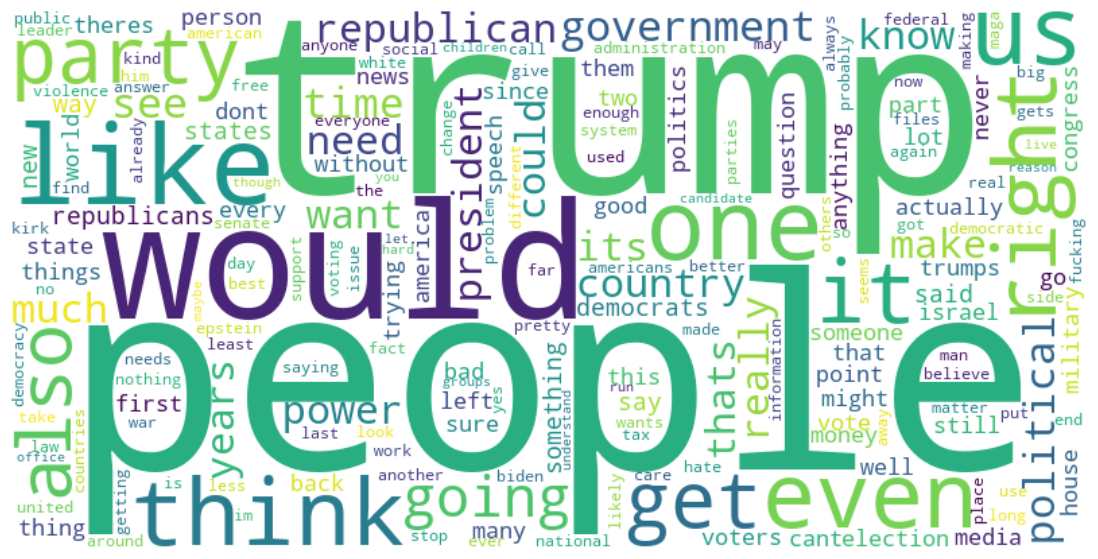

In [50]:
#Visualization 

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

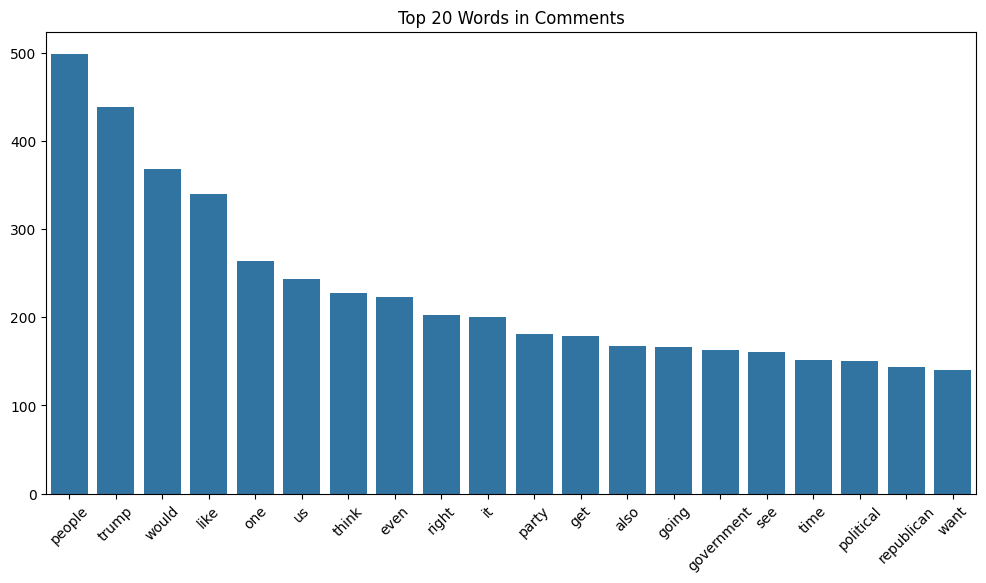

In [51]:
import seaborn as sns
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("Top 20 Words in Comments")
plt.show()

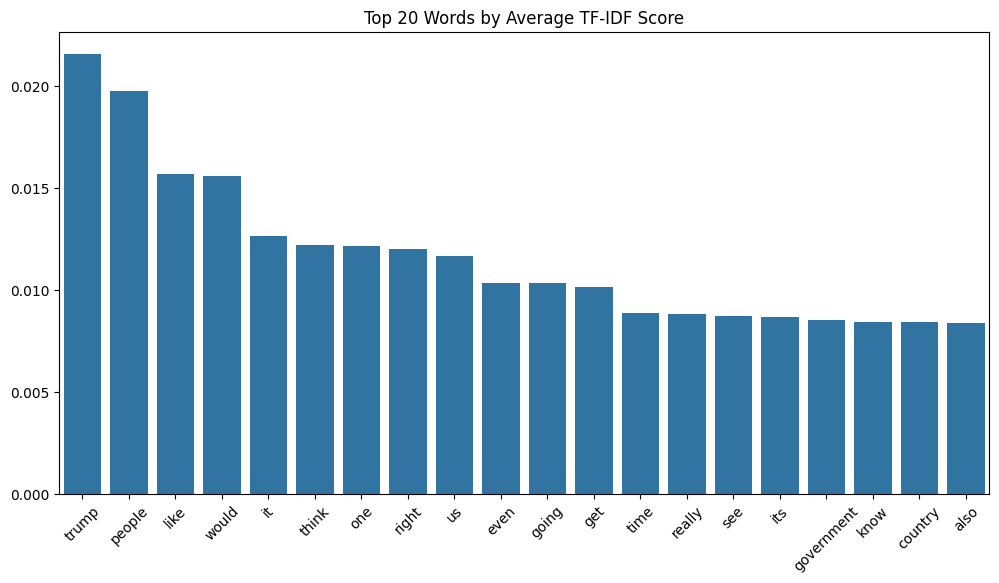

In [52]:
# Compute average TF-IDF score per feature
avg_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).ravel()
top_indices = avg_tfidf.argsort()[-20:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = avg_tfidf[top_indices]

plt.figure(figsize=(12,6))
sns.barplot(x=top_features, y=top_scores)
plt.xticks(rotation=45)
plt.title("Top 20 Words by Average TF-IDF Score")
plt.show()

In [53]:
avg_tfidf_per_comment = np.asarray(tfidf_matrix.mean(axis=1)).ravel()
top_comment_indices = avg_tfidf_per_comment.argsort()[-50:][::-1]
top_comments = df['comment'].iloc[top_comment_indices]
top_scores = avg_tfidf_per_comment[top_comment_indices]

top_comments

1929    killing charlie kirk met restraint evidence co...
1422    compendium notable charlie kirk statements  at...
510     compendium notable charlie kirk statements  tu...
2992    devil often details long short dnc rnc collude...
270     need start wearing trump masks peaceful protes...
1680    inappropriately illegally fires punishes peopl...
1777    even reagan least became president moderate re...
1488    ways sort getting cause effect mixed up right ...
708     full text  trumps goons topple 12foot statue e...
1750    look closer statement opined here pressure cam...
274     paywall httpswwwyahoocomnewsarticlesviralmagaa...
2144    three polls came within days last week mayors ...
1749    us government long claimed power censure infor...
105     just another episode never ending adventure co...
1762    trump mishandled response pandemic thought pol...
720     robert mccoys article colombian president gust...
3045    theres actual evidence ad swayed many people o...
2958    proble